In [2]:
%run ~/common_init.py
import flamedisx as fd
import tensorflow as tf
#fd.utils.FLOAT_TYPE = tf.float64
fd.float_type()

Active python: /home/jelle/miniconda3/envs/py37/bin/python


tf.float32

In [22]:
er_source = fd.SR0ERSource()
rn_data = pd.read_csv('data_Rn220_lowenergy.csv')[::32]
er_source.annotate_data(rn_data)
rn_data = rn_data[rn_data['e_vis'] < 10].copy()
ll = fd.LogLikelihood(
    sources=dict(er=er_source),
    free_rates='er',
    data=rn_data,
    elife=(300e3, 500e3, 3),
    erqy_a=(5., 25., 2),
    erqy_b=(-29., -26., 2),
    erqy_c=(31.9, 32.8, 2),
    g2=(25., 35., 2),
    n_trials=int(2e5))
len(rn_data), len(rn_data) / ll.mu_itps['er']().numpy()

Estimating mus: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


(18, 0.020753585583171377)

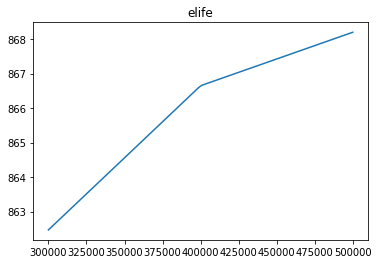

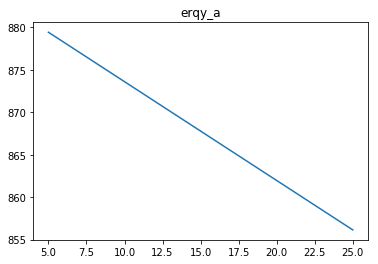

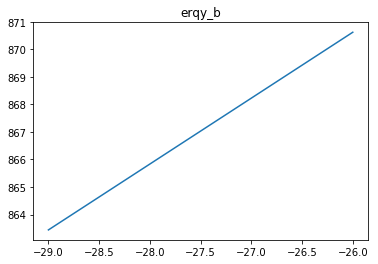

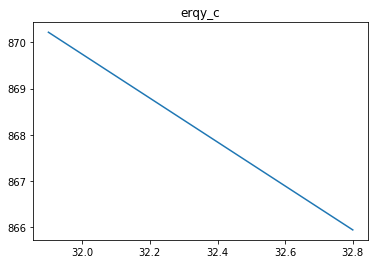

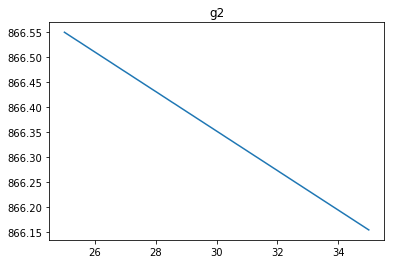

In [23]:
for pname in ll.param_names:
    if pname.endswith('_rate_multiplier'):
        continue
    start, stop, n = ll.param_specs[pname]
    x = np.linspace(start, stop, 100, dtype=np.float32)
    y = np.array([ll.mu_itps['er'](**{pname: tf.constant(q)}) for q in x])
    plt.plot(x, y)
    plt.title(pname)
    plt.show()

In [24]:
guess = ll.guess().numpy()
guess[0] = 0.01
bestfit = ll.bestfit(guess)
inv_hess = ll.inverse_hessian(bestfit)
ll.summary(bestfit, inverse_hessian=inv_hess)

Computing hessian: 100%|██████████| 6/6 [01:23<00:00, 15.83s/it]

er_rate_multiplier: 0.00921 +- 0.00236
elife: 4.34e+05 +- 4.84e+04
erqy_a: 14.5 +- 27.4
erqy_b: -32.1 +- 6.98
erqy_c: 32.8 +- 3.33
g2: 32.4 +- 1.76
Correlation matrix:
                    er_rate_multiplier  elife  erqy_a  erqy_b  erqy_c  \
er_rate_multiplier           1.000e+00 -0.003   0.146   0.064  -0.080   
elife                       -2.567e-03  1.000   0.006   0.362  -0.621   
erqy_a                       1.459e-01  0.006   1.000   0.449  -0.564   
erqy_b                       6.420e-02  0.362   0.449   1.000  -0.648   
erqy_c                      -8.024e-02 -0.621  -0.564  -0.648   1.000   
g2                           6.193e-04 -0.142  -0.001   0.008  -0.283   

                           g2  
er_rate_multiplier  6.193e-04  
elife              -1.424e-01  
erqy_a             -1.292e-03  
erqy_b              8.372e-03  
erqy_c             -2.832e-01  
g2                  1.000e+00  


In [ ]:
er_source_s = fd.SR0ERSource()
er_source_s.set_data(rn_data)
n_trials = int(1e5)

sim_guess = er_source_s.simulate(n_trials,
                                **ll.params_to_dict(guess))
sim_bf = er_source_s.simulate(n_trials, 
                              **ll.params_to_dict(bestfit.numpy()))

bins = np.linspace(0, 11, 10)
for d_sim in sim_guess, sim_bf:
    Histdd(d_sim, dimensions=(
        ('e_vis', np.linspace(0, 11, 50)),
        ('electron_produced_mle', np.linspace(0, 350, 50)),
    )).plot()
    d = rn_data
    plt.scatter(d['e_vis'], d['electron_produced_mle'], c='white', s=5)
    plt.show()


# OLD

In [9]:
# @tf.function
# def bla(x):
#     y = ll.minus_ll(x)
#     #grads = tf.gradients(y, x)
#     return tf.hessians(y, x)

# logdir = '/tmp/summaries/bla'
# writer = tf.summary.create_file_writer(logdir)
# tf.summary.trace_on(graph=True, profiler=True)
# # Forward pass
# bla(bestfit)
# with writer.as_default():
#     tf.summary.trace_export(name="bla", step=0, profiler_outdir=logdir)